In [215]:
import numpy as np
from plotnine import *
import pandas as pd

In [216]:
results = pd.read_csv("benchmark_results.csv", sep='\t')

In [217]:
nbse_info = pd.read_csv("nbse_sets.csv")

In [218]:
data = results.merge(nbse_info, left_on=['name'], right_on=['set_name'])
data['mcs_size_to_atom_size'] = data['mcs_atoms'] / data['avg_atoms']
data = data.query('local_similarity > 0 and took < 900')
data.set_index(['name', 'optimizer_steps', 'optimizer_fine', 'optimizer_coarse', 'num_conformers', 'core', 'assemblies'])

,,,,,,,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,divide,set_name,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,avg_atoms_to_mcs,mcs_size_to_atom_size
name,optimizer_steps,optimizer_fine,optimizer_coarse,num_conformers,core,assemblies,,,,,,,,,,,,,,,,
3ke8,100,0.01,0.3,40,mcs,10,18,0.664895,0.629946,2.792387,True,3ke8,17,17,12,11,11,17,14.647,NaN,75.10%,0.751007
2vke,100,0.01,0.3,40,mcs,10,218,0.653470,0.613581,2.697748,True,2vke,42,45,31,34,22,12,33.522,NaN,65.63%,0.656285
1odn,100,0.01,0.3,40,mcs,10,303,0.569305,0.657672,3.152543,True,1odn,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
4dko,100,0.01,0.3,40,mcs,10,43,0.579109,0.458960,4.240663,True,4dko,30,33,23,24,15,13,26.077,NaN,57.52%,0.575220
3qqs,100,0.01,0.3,40,mcs,10,48,0.619915,0.311268,5.187691,True,3qqs,29,31,10,10,8,19,14.789,NaN,54.09%,0.540943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3g5h,100,0.01,0.3,20,mcs,10,53,0.479303,0.392778,4.959301,True,3g5h,27,30,12,13,6,18,19.222,NaN,31.21%,0.312142
3tfu,100,0.01,0.3,20,mcs,10,14,0.345030,0.481296,5.599819,True,3tfu,28,30,11,12,6,13,19.462,NaN,30.83%,0.308293
3id8,100,0.01,0.3,20,mcs,10,160,0.308676,0.538214,6.718176,True,3id8,37,41,19,21,9,12,29.333,NaN,30.68%,0.306822


In [219]:
data.describe()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,mcs_size_to_atom_size
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.00,188.000000,188.000000,188.0,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,0.0,188.000000
mean,129.606383,0.517591,0.469411,4.112491,0.400000,0.01,28.563830,5.500000,100.0,31.648936,34.212766,15.308511,15.952128,9.361702,17.117021,22.696048,NaN,0.413879
std,111.220427,0.097872,0.112760,1.421621,0.100267,0.00,17.839485,4.512016,0.0,8.650934,9.653209,4.851873,5.539633,3.574572,6.140697,5.656836,NaN,0.114151
min,1.000000,0.307021,0.174775,1.647598,0.300000,0.01,10.000000,1.000000,100.0,12.000000,12.000000,9.000000,9.000000,4.000000,12.000000,10.769000,NaN,0.298533
25%,45.000000,0.448015,0.387418,2.926832,0.300000,0.01,10.000000,1.000000,100.0,26.000000,29.000000,11.000000,11.000000,7.000000,13.000000,19.176000,NaN,0.318590
50%,102.000000,0.521924,0.480391,3.970395,0.400000,0.01,30.000000,5.500000,100.0,30.000000,32.000000,14.000000,15.000000,9.000000,15.000000,21.560000,NaN,0.375834
75%,187.250000,0.587124,0.540670,5.146633,0.500000,0.01,40.000000,10.000000,100.0,37.000000,41.000000,18.000000,20.000000,11.000000,19.000000,26.077000,NaN,0.475160
max,851.000000,0.719335,0.737755,8.482188,0.500000,0.01,60.000000,10.000000,100.0,73.000000,80.000000,31.000000,34.000000,22.000000,40.000000,37.294000,NaN,0.751007


In [220]:
metrics = data.drop(columns=['set_name', 'name', 'divide', 'core', 'mcs_bonds', 'avg_atoms_to_mcs'])
metrics.var()

took                           12369.983275
local_similarity                   0.009579
avg_conformer_tanimoto_dist        0.012715
siena_rmsd                         2.021007
optimizer_coarse                   0.010053
optimizer_fine                     0.000000
num_conformers                   318.247241
assemblies                        20.358289
optimizer_steps                    0.000000
most_atoms                        74.838662
most_bonds                        93.184435
least_atoms                       23.540676
least_bonds                       30.687536
mcs_atoms                         12.777563
num_mols                          37.708158
avg_atoms                         31.999789
mcs_size_to_atom_size              0.013031
dtype: float64

In [221]:
metrics.head()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_size_to_atom_size
0,18,0.664895,0.629946,2.792387,0.3,0.01,40,10,100,17,17,12,11,11,17,14.647,0.751007
1,218,0.653470,0.613581,2.697748,0.3,0.01,40,10,100,42,45,31,34,22,12,33.522,0.656285
2,303,0.569305,0.657672,3.152543,0.3,0.01,40,10,100,30,29,18,17,15,28,24.251,0.618531
3,43,0.579109,0.458960,4.240663,0.3,0.01,40,10,100,30,33,23,24,15,13,26.077,0.575220
4,48,0.619915,0.311268,5.187691,0.3,0.01,40,10,100,29,31,10,10,8,19,14.789,0.540943


In [222]:
correlations = metrics.corr(method='pearson')
correlations.head()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_size_to_atom_size
took,1.000000,-0.299954,0.055009,0.237949,-0.180495,NaN,-0.000179,0.180495,NaN,0.515946,0.495373,0.166582,0.140455,0.096184,0.537113,0.300087,-0.170671
local_similarity,-0.299954,1.000000,-0.165430,-0.783387,-0.022932,NaN,0.034168,0.022932,NaN,-0.495289,-0.511953,-0.088699,-0.148703,0.171405,0.031945,-0.379076,0.554840
avg_conformer_tanimoto_dist,0.055009,-0.165430,1.000000,0.102399,-0.018645,NaN,-0.004464,0.018645,NaN,0.408890,0.365629,0.587836,0.569664,0.566215,-0.201856,0.665437,0.220585
siena_rmsd,0.237949,-0.783387,0.102399,1.000000,-0.003634,NaN,-0.000599,0.003634,NaN,0.474322,0.488770,0.069729,0.127552,-0.167879,-0.007497,0.267203,-0.418660
optimizer_coarse,-0.180495,-0.022932,-0.018645,-0.003634,1.000000,NaN,0.284015,-1.000000,NaN,-0.002466,-0.005525,0.015389,0.014441,0.008952,0.003474,-0.001202,0.008359


In [223]:
corr = correlations.stack().reset_index()
corr.columns = ['var1', 'var2', 'val']

metric_cols = ['took', 'siena_rmsd', 'avg_conformer_tanimoto_dist', 'local_similarity']
corr_config = corr[corr['var2'].isin(metric_cols)]
corr_config = corr_config[~corr_config['var1'].isin(metric_cols)]

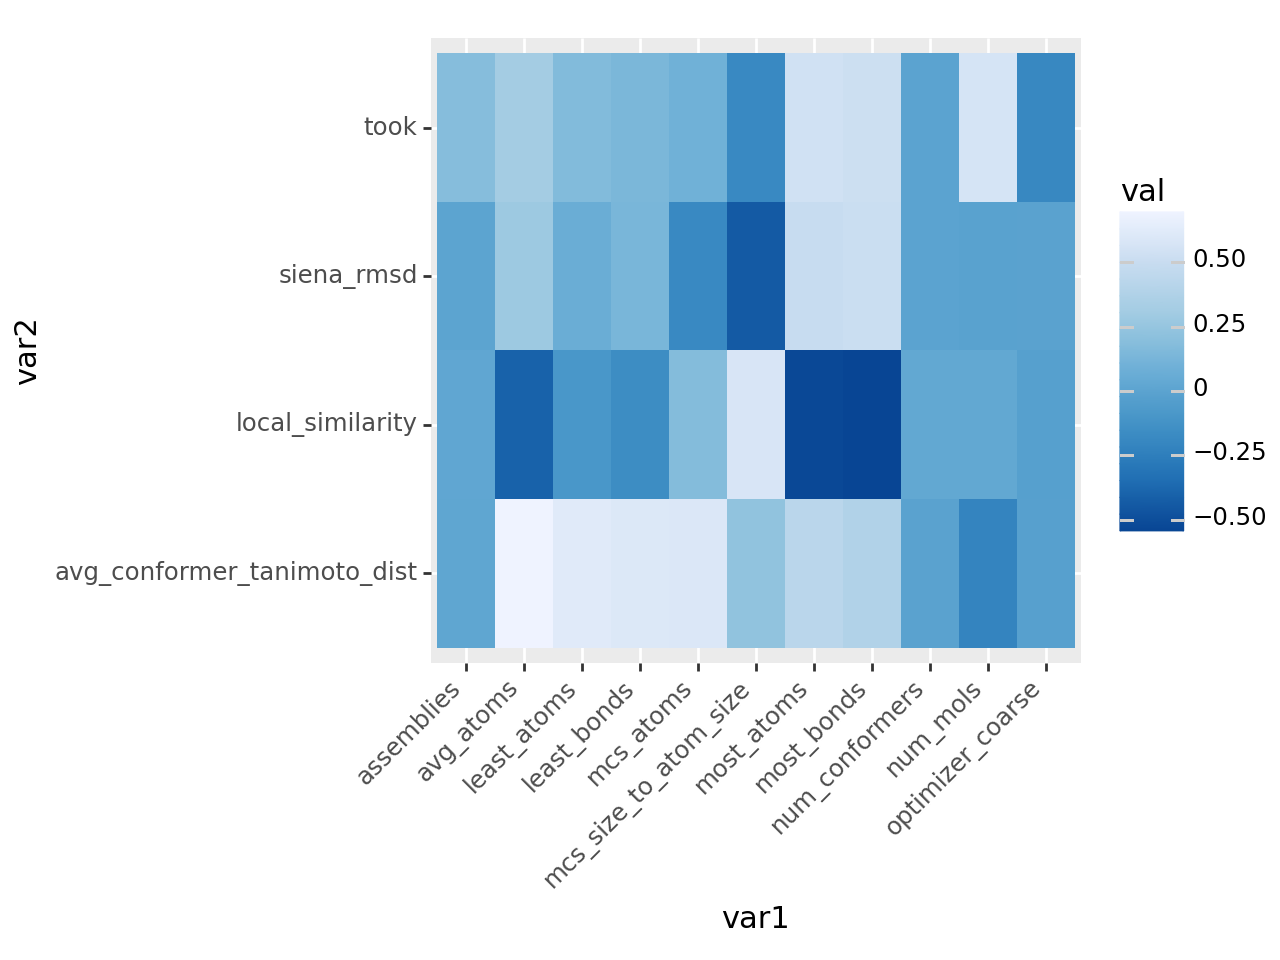

<Figure Size: (640 x 480)>

In [224]:
(ggplot(corr_config, mapping=aes('var1', 'var2', fill='val'))
 + geom_tile()
 + scale_fill_distiller()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [225]:
corr_metrics = corr[corr['var1'].isin(metric_cols) & corr['var2'].isin(metric_cols)]

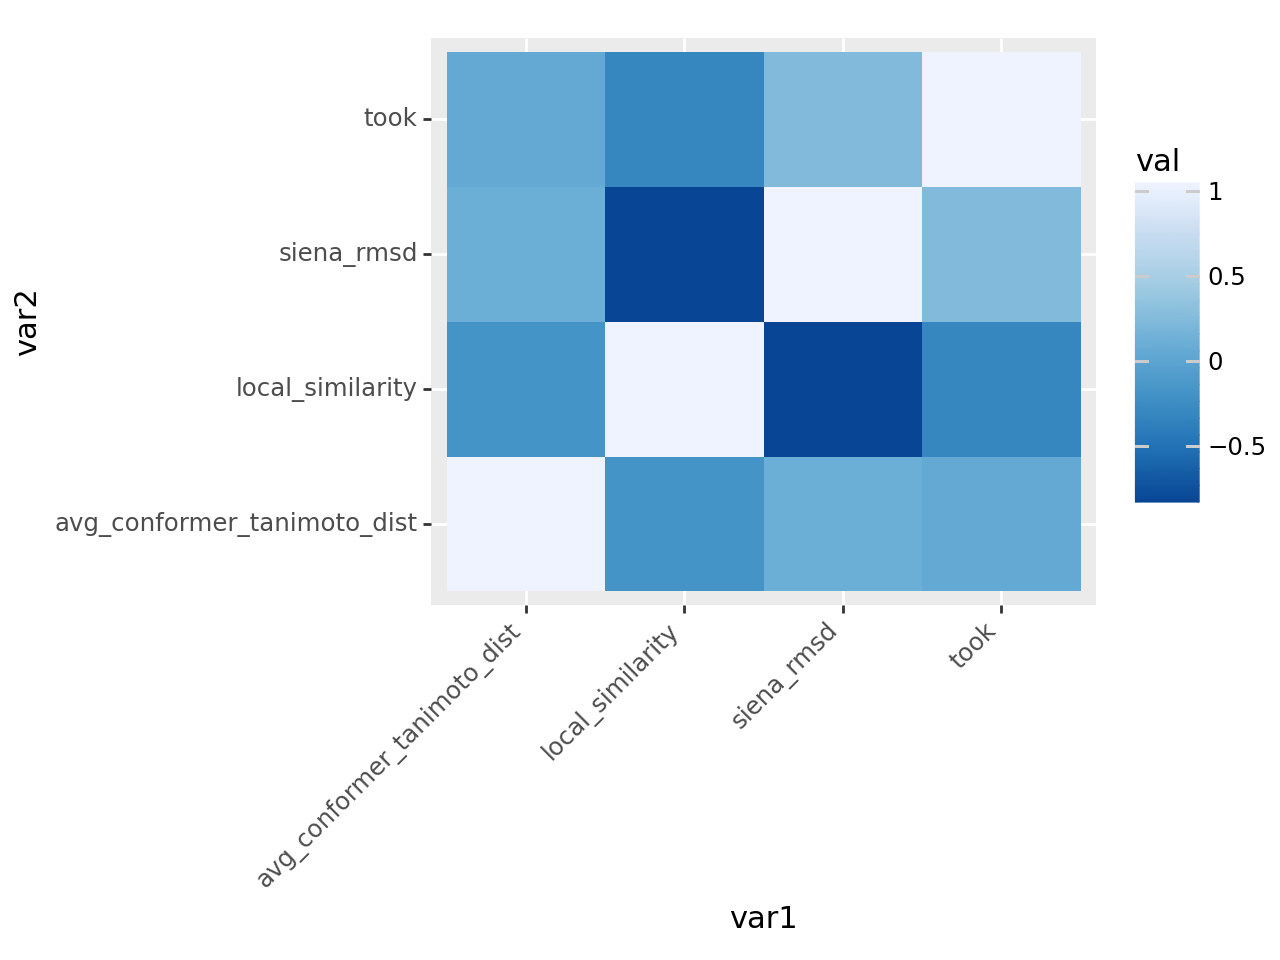

<Figure Size: (640 x 480)>

In [226]:
(ggplot(corr_metrics, mapping=aes('var1', 'var2', fill='val'))
 + geom_tile()
 + scale_fill_distiller()
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))


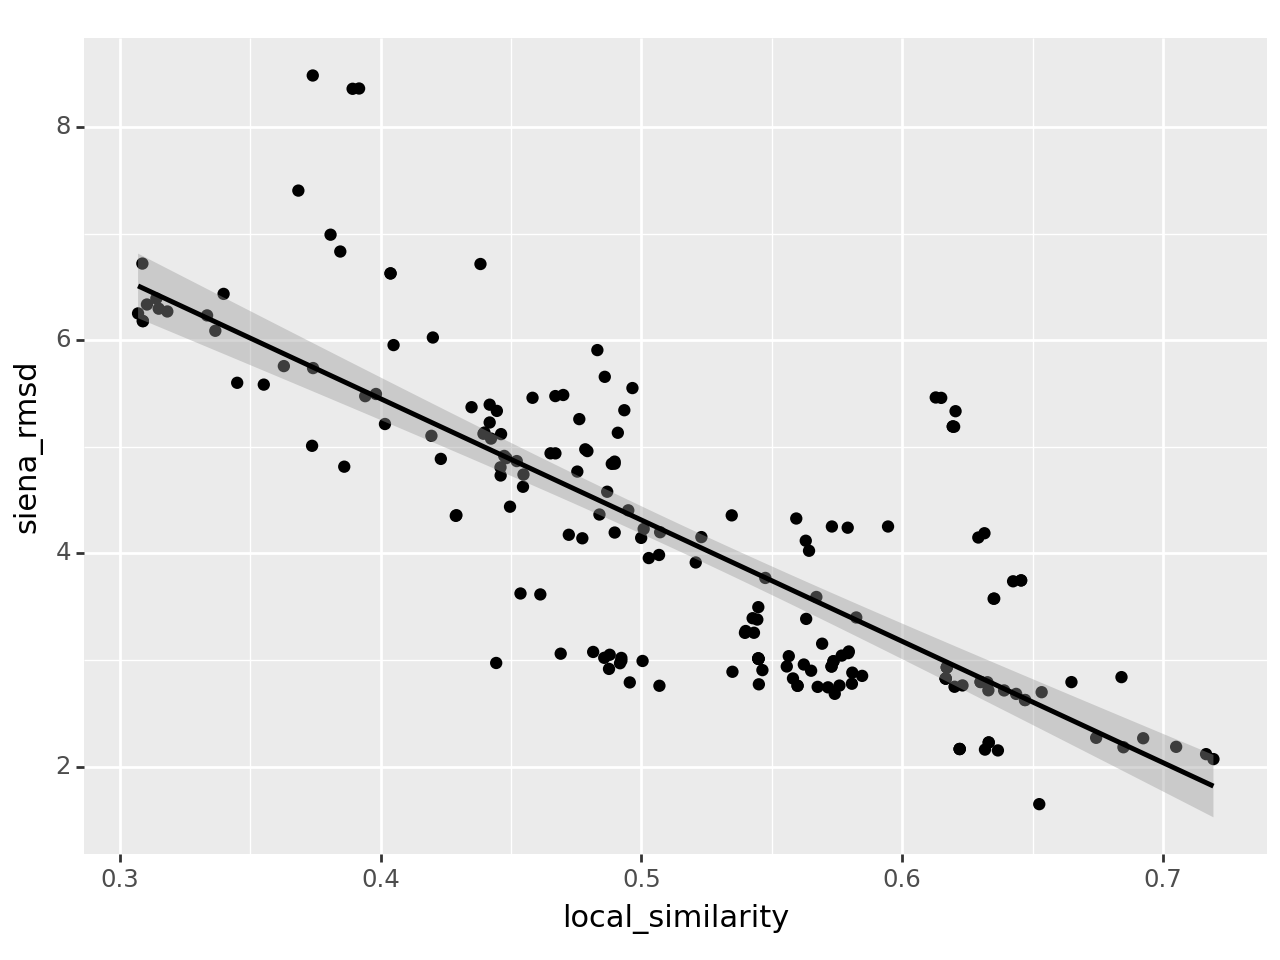

<Figure Size: (640 x 480)>

In [227]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm'))

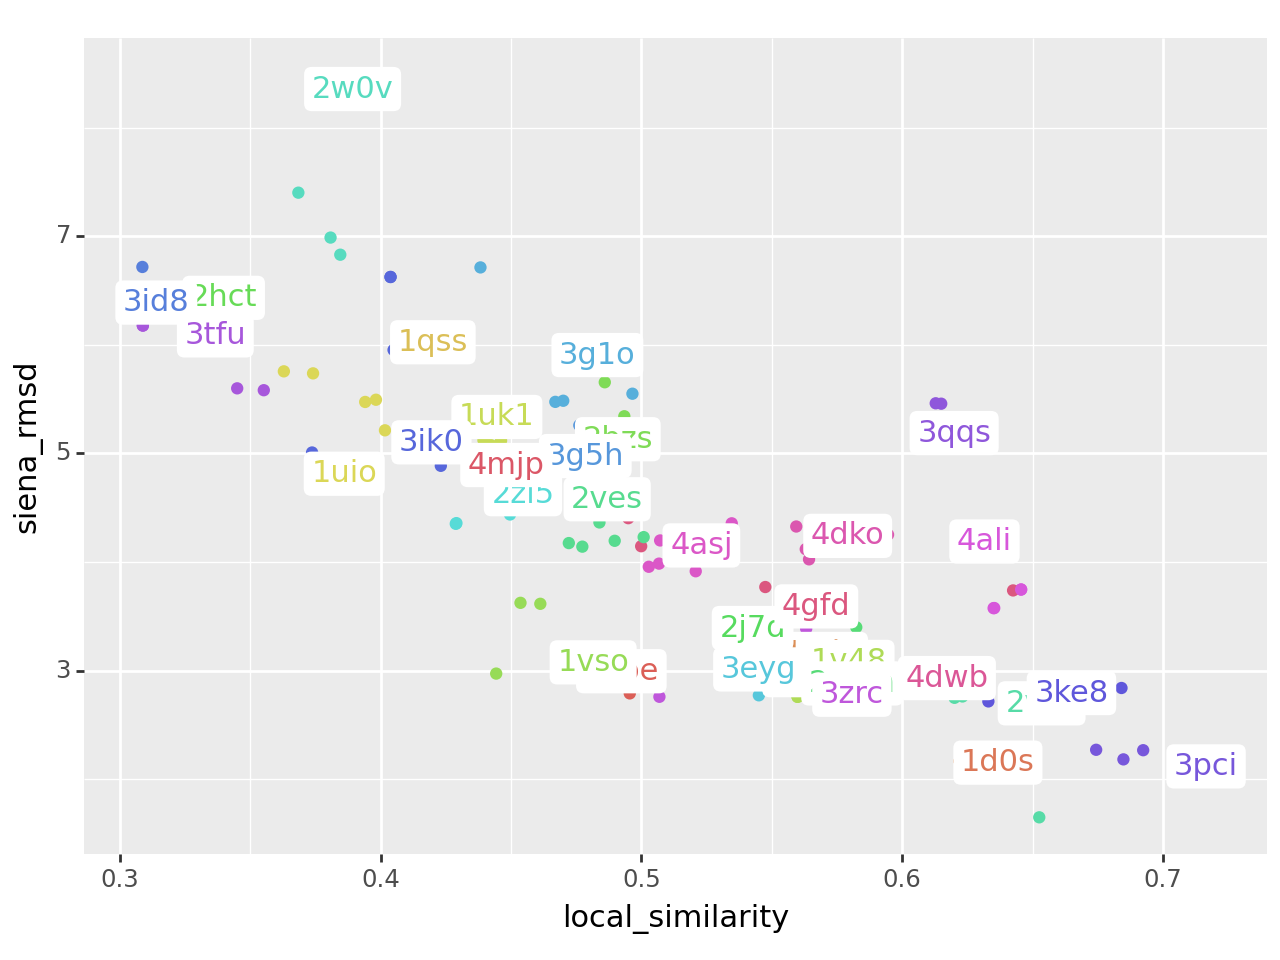

<Figure Size: (640 x 480)>

In [228]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1,1,1,0) )
 +scale_color_discrete(guide=False)
 )


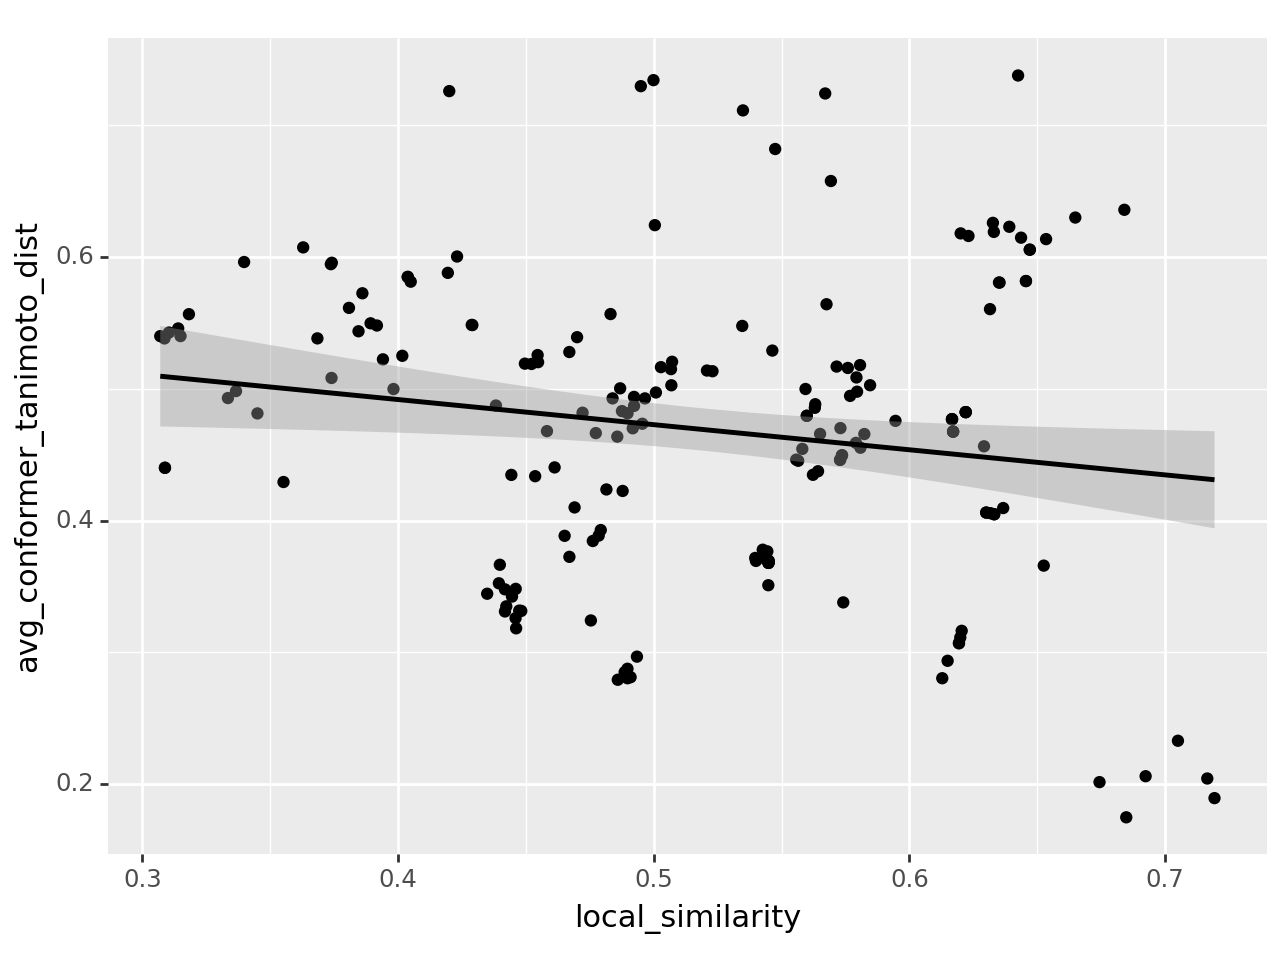

<Figure Size: (640 x 480)>

In [229]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='avg_conformer_tanimoto_dist'))
 + geom_point()
 + geom_smooth(method='lm'))

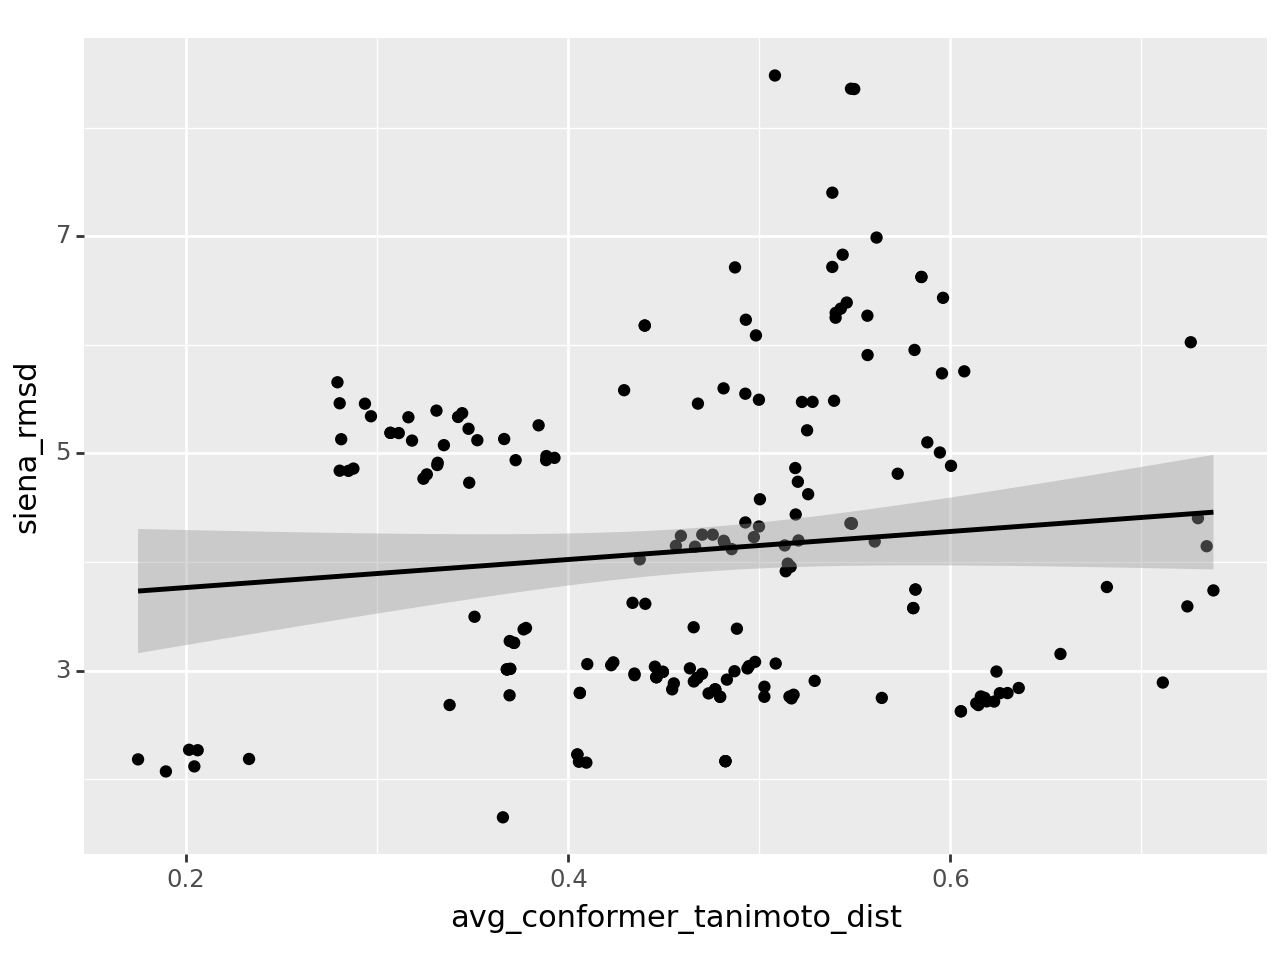

<Figure Size: (640 x 480)>

In [230]:
(ggplot(data=data, mapping=aes(x='avg_conformer_tanimoto_dist', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm'))


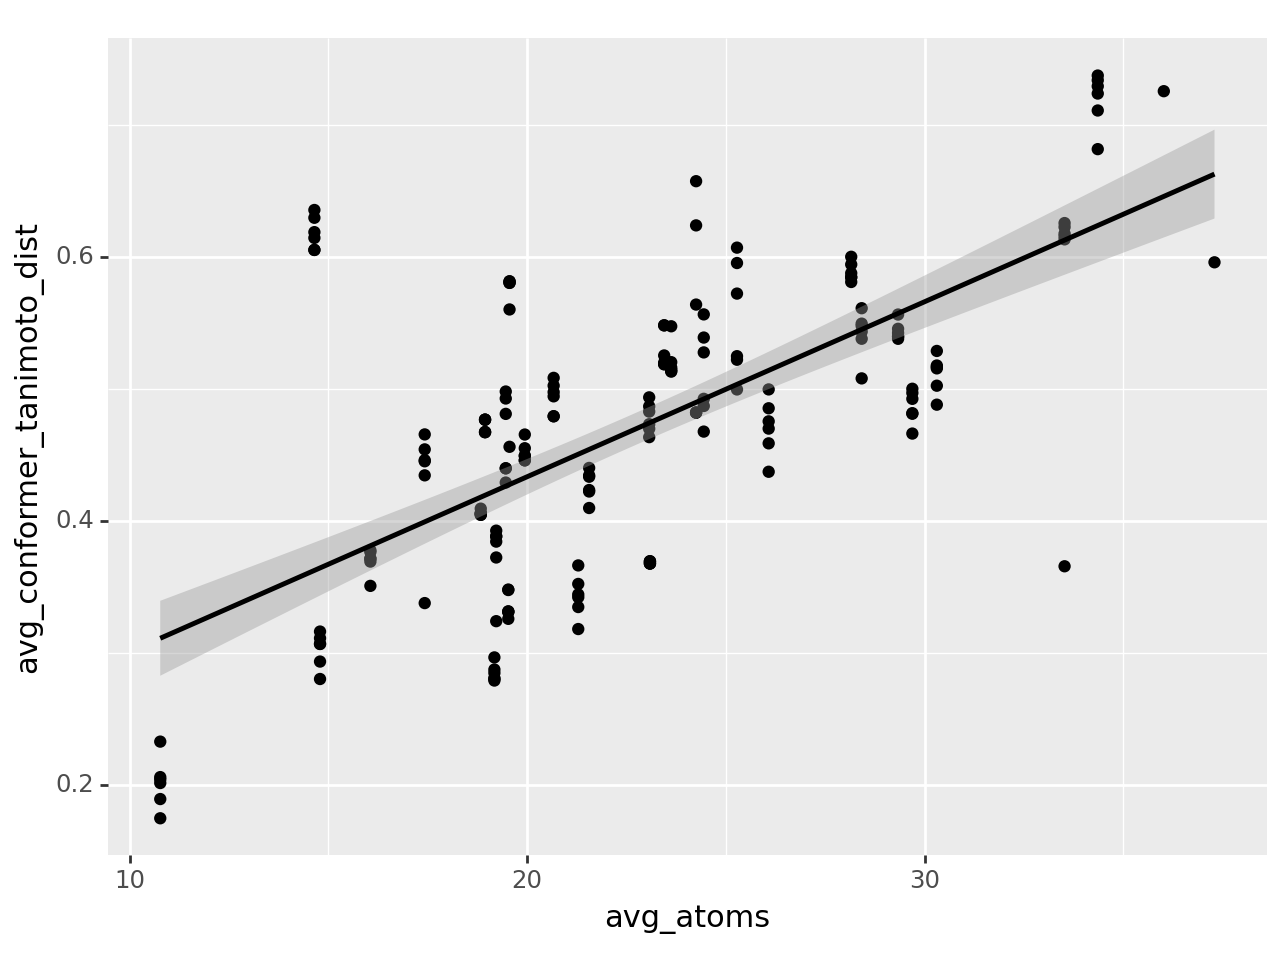

<Figure Size: (640 x 480)>

In [231]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist'))
 + geom_point()
 + geom_smooth(method='lm'))

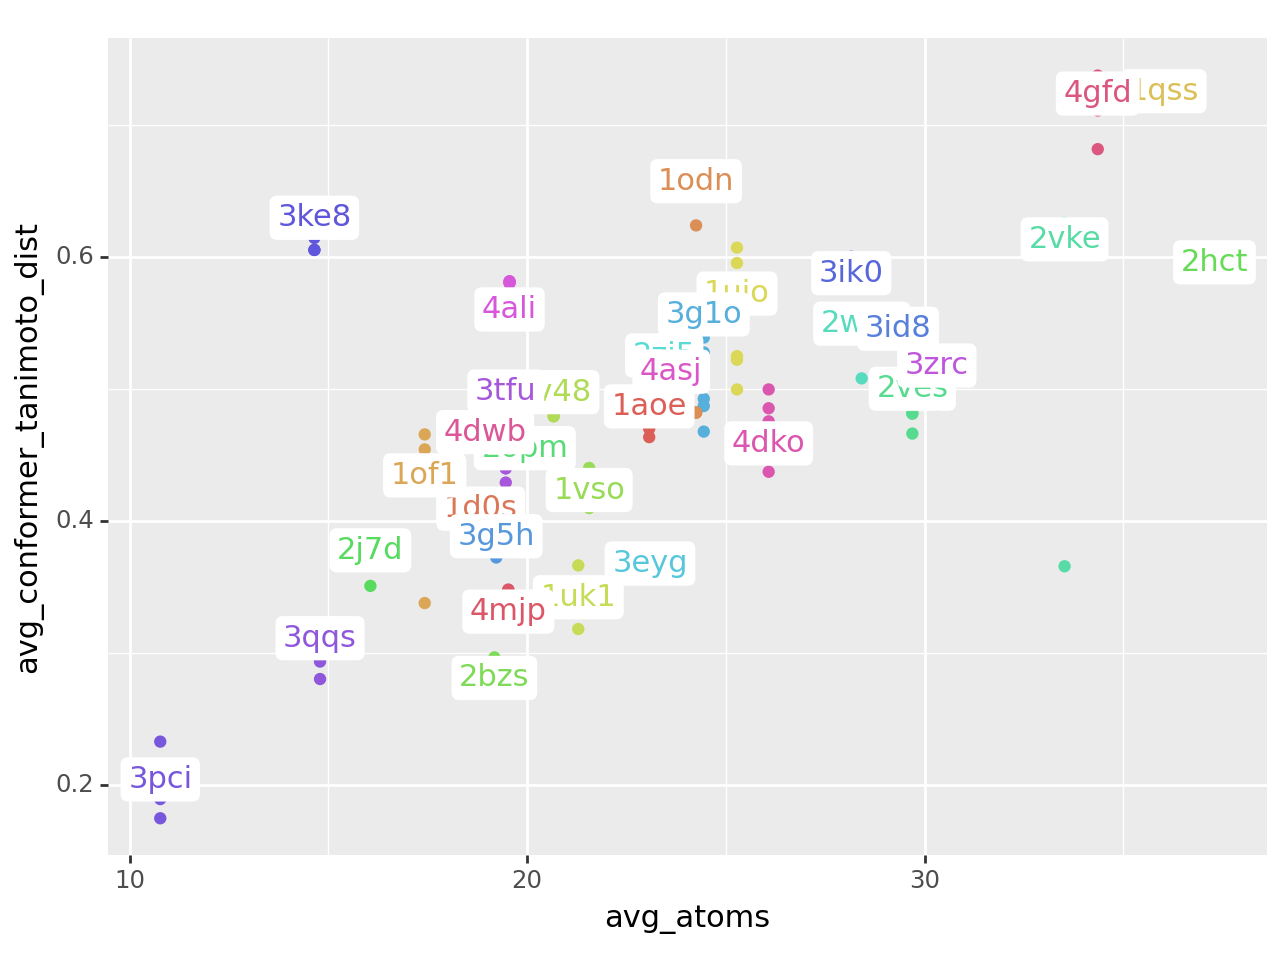

<Figure Size: (640 x 480)>

In [232]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1,1,1,0) )
 +scale_color_discrete(guide=False)
 )


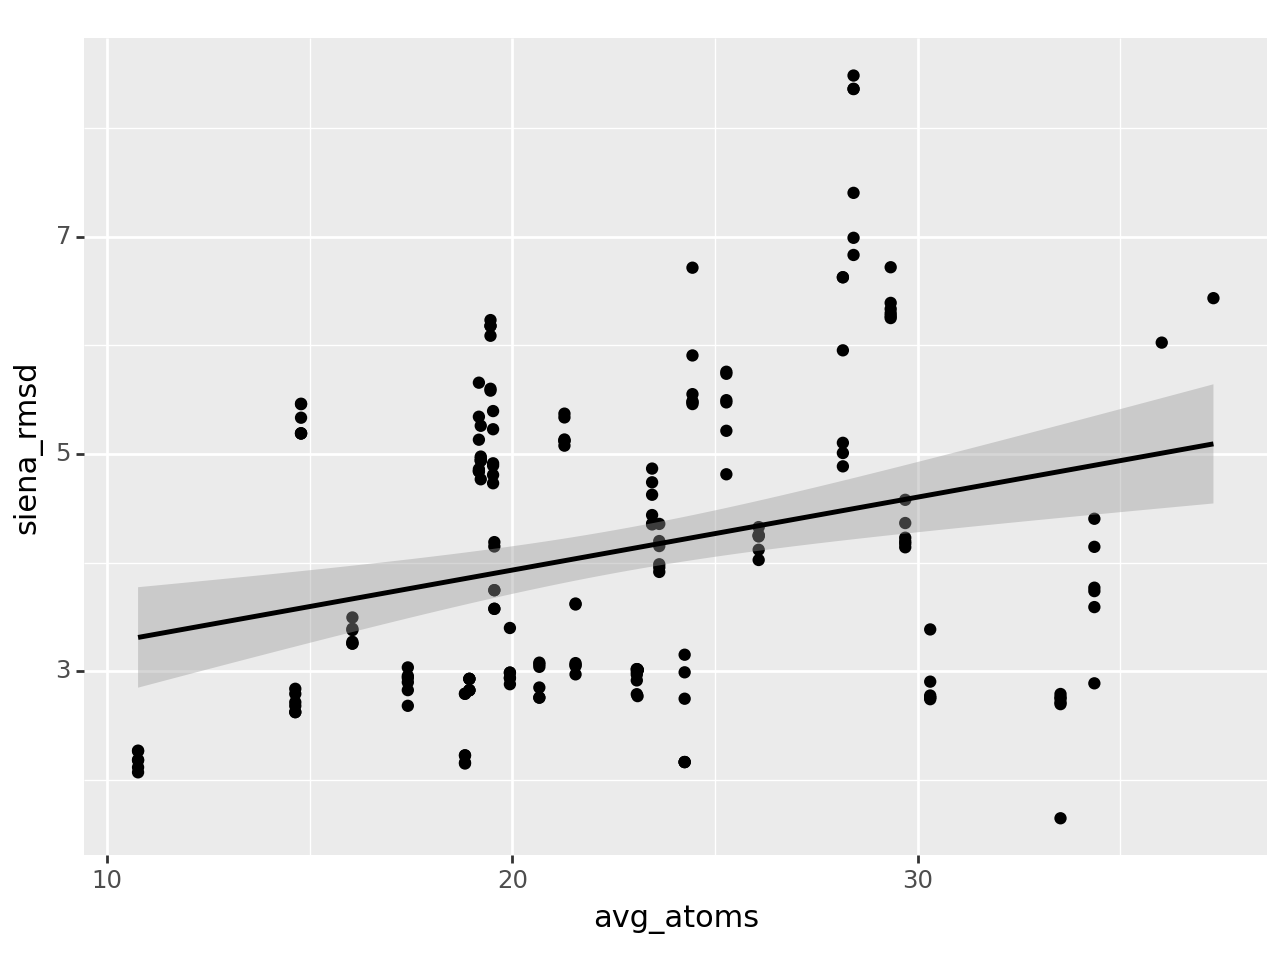

<Figure Size: (640 x 480)>

In [233]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm'))

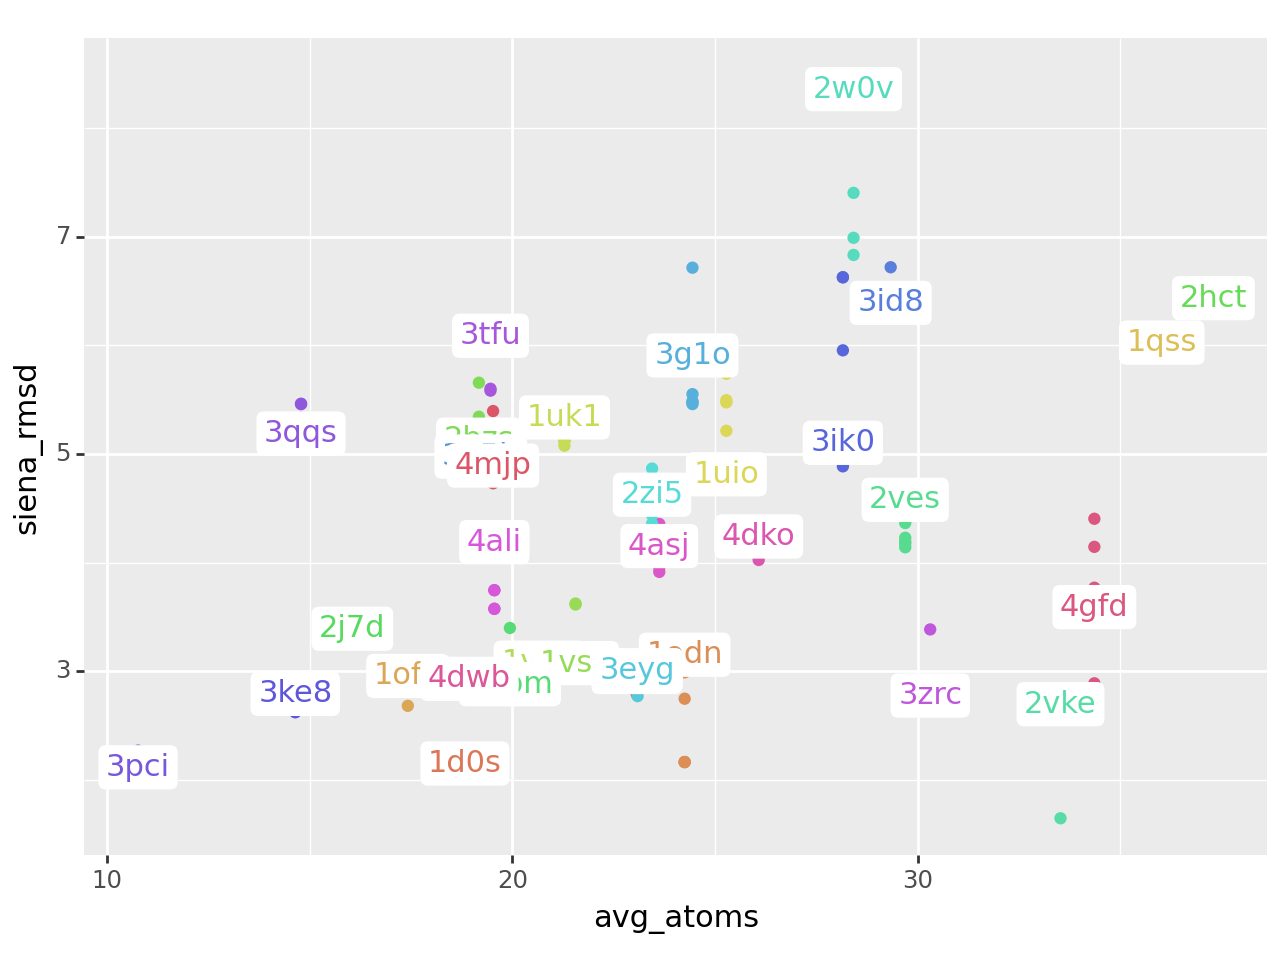

<Figure Size: (640 x 480)>

In [234]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='siena_rmsd', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1,1,1,0) )
 +scale_color_discrete(guide=False)
 )


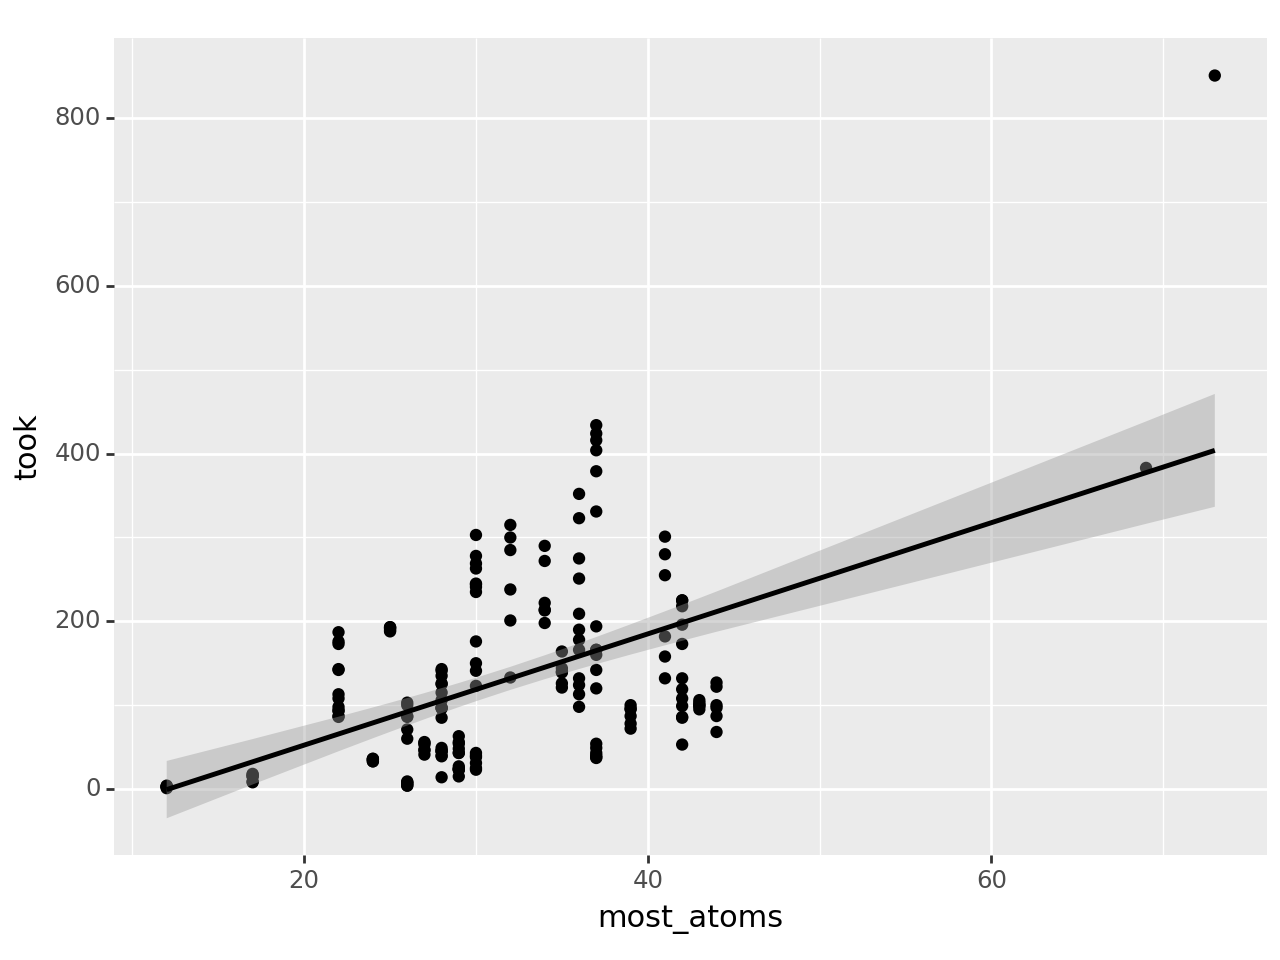

<Figure Size: (640 x 480)>

In [235]:
(ggplot(data=data, mapping=aes(x='most_atoms', y='took'))
 + geom_point()
 + geom_smooth(method='lm'))

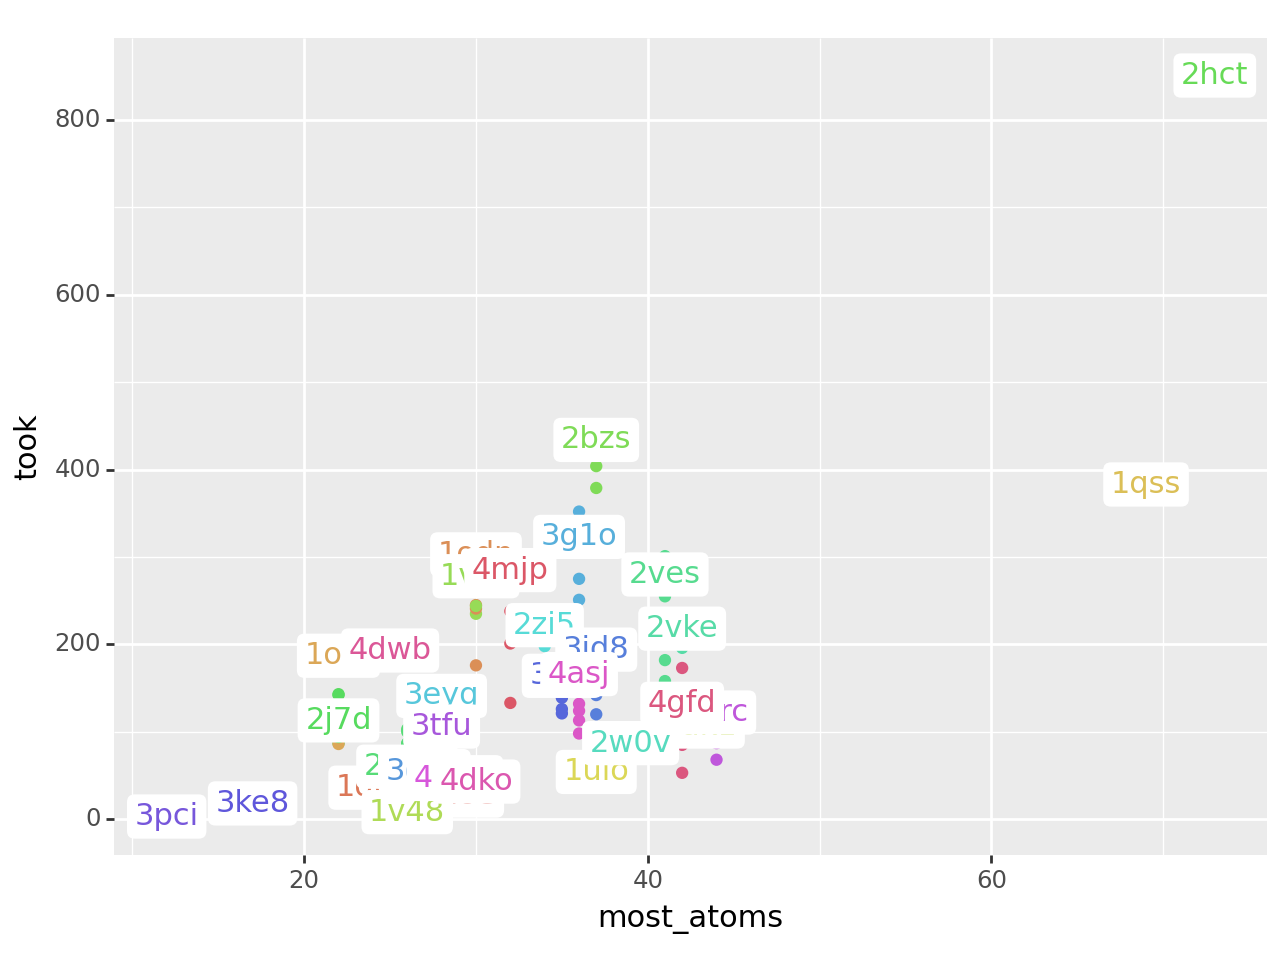

<Figure Size: (640 x 480)>

In [236]:
(ggplot(data=data, mapping=aes(x='most_atoms', y='took', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1,1,1,0) )
 +scale_color_discrete(guide=False)
 )